# Введение

Нас (возможно и вас) пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

# Ознакомление
Для начала загрузим файл в датафрейм (ДФ), переименуем некоторые колонки для удобства и посмотрим развернутый ДФ.

In [79]:
students = pd.read_csv('stud_math.csv')
students.rename(columns={'studytime, granular': 'studytime_granular',
                         'Pstatus': 'pstatus', 'Medu': 'medu', 'Fedu': 'fedu',
                         'Mjob': 'mjob', 'Fjob': 'fjob'}, inplace=True)
pd.set_option('max_columns', None)

In [54]:
students.sample(10)

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
223,GP,M,18,U,GT3,T,2.0,2.0,other,other,home,NaN,2.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,65.0
116,GP,M,15,U,GT3,T,4.0,4.0,other,teacher,reputation,father,2.0,2.0,0.0,no,yes,no,NaN,yes,-6.0,yes,no,no,4.0,4.0,3.0,2.0,2.0,70.0
30,GP,M,15,U,GT3,T,4.0,4.0,health,services,home,mother,NaN,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,no,5.0,4.0,2.0,NaN,0.0,60.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
157,GP,F,18,R,GT3,T,1.0,1.0,at_home,other,course,mother,NaN,1.0,3.0,no,yes,no,yes,no,-3.0,yes,no,no,5.0,2.0,5.0,4.0,6.0,50.0
45,GP,F,15,U,LE3,A,4.0,3.0,other,other,course,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,yes,5.0,2.0,2.0,5.0,8.0,30.0
123,GP,M,16,U,GT3,T,4.0,4.0,health,other,course,mother,1.0,1.0,0.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,4.0,4.0,5.0,18.0,65.0
266,GP,M,17,U,GT3,NaN,3.0,1.0,services,NaN,other,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,NaN,5.0,4.0,4.0,NaN,2.0,50.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0


#### Значения колонок датафрейма

school — аббревиатура школы, в которой учится ученик

sex — пол ученика ('F' - женский, 'M' - мужской)

age — возраст ученика (от 15 до 22)

address — тип адреса ученика ('U' - городской, 'R' - за городом)

famsize — размер семьи('LE3' <= 3, 'GT3' >3)

Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

schoolsup — дополнительная образовательная поддержка (yes или no)

famsup — семейная образовательная поддержка (yes или no)

paid — дополнительные платные занятия по математике (yes или no)

activities — дополнительные внеучебные занятия (yes или no)

nursery — посещал детский сад (yes или no)

higher — хочет получить высшее образование (yes или no)

internet — наличие интернета дома (yes или no)

romantic — в романтических отношениях (yes или no)

famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

absences — количество пропущенных занятий

score — баллы по госэкзамену по математике

In [55]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   pstatus             350 non-null    object 
 6   medu                392 non-null    float64
 7   fedu                371 non-null    float64
 8   mjob                376 non-null    object 
 9   fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

В датасете всего 30 колонок: 13 числовых колонок и 17 строковых. 
Датасете содержит данные данные о 395 учениках.
Во всех колонках, кроме school, sex, age есть пустые значения.

In [106]:
type(students.sex)

pandas.core.series.Series

# Очистка данных

In [110]:
# Функция для получения быстрой справки о данных в колонках
def info(x):
    print(pd.DataFrame(x.value_counts()))
    print('Пропущенных значений -', x.isnull().values.sum())
    x.hist()

### Просмотр числовыx столбцов

    age
16  104
17   98
18   82
15   82
19   24
20    3
22    1
21    1
Пропущенных значений - 0


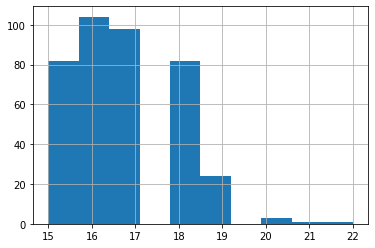

In [111]:
info(students.age)

     medu
4.0   131
2.0   102
3.0    97
1.0    59
0.0     3
Пропущенных значений - 3


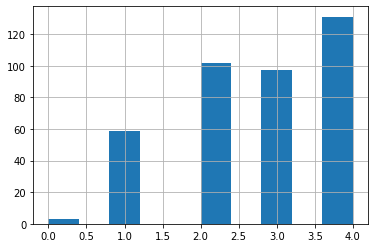

In [112]:
info(students.medu)

      fedu
2.0    106
3.0     96
4.0     88
1.0     78
0.0      2
40.0     1
Пропущенных значений - 24


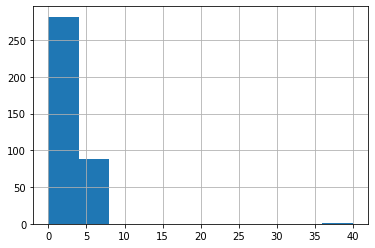

In [59]:
info(students.fedu)

Исправим опечатку значения 40.0, вероятно имелось ввиду 4.

In [60]:
students.fedu = students.fedu.apply(lambda x: x/10 if x > 9 else x)

     traveltime
1.0         242
2.0          96
3.0          22
4.0           7
Пропущенных значений - 28


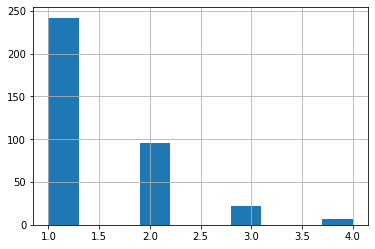

In [61]:
info(students.traveltime)

     studytime
2.0        194
1.0        103
3.0         64
4.0         27
Пропущенных значений - 7


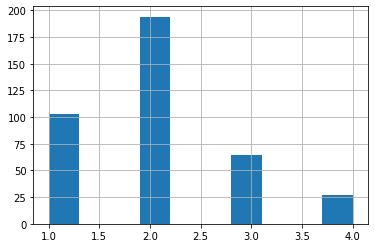

In [62]:
info(students.studytime)

     failures
0.0       293
1.0        49
2.0        16
3.0        15
Пропущенных значений - 22


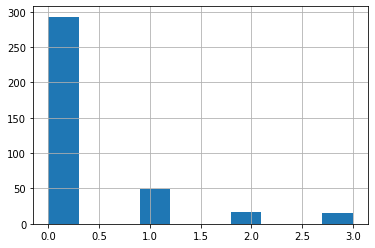

In [63]:
info(students.failures)

       studytime_granular
-6.0                  194
-3.0                  103
-9.0                   64
-12.0                  27
Пропущенных значений - 7


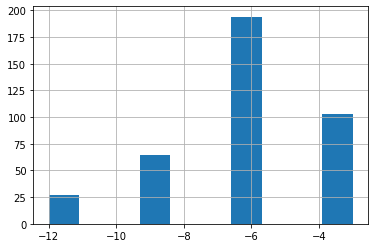

In [64]:
info(students.studytime_granular)

      famrel
 4.0     182
 5.0      99
 3.0      62
 2.0      17
 1.0       7
-1.0       1
Пропущенных значений - 27


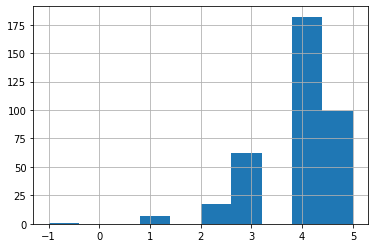

In [65]:
info(students.famrel)

Исправим опечатку значения -1.0, вероятно имелось ввиду 1.0

In [66]:
students.famrel = students.famrel.apply(lambda x: abs(x) if x < 0 else x)

     freetime
3.0       153
4.0       112
2.0        63
5.0        38
1.0        18
Пропущенных значений - 11


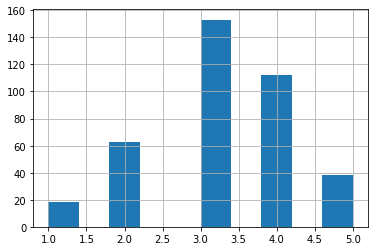

In [67]:
info(students.freetime)

     goout
3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
Пропущенных значений - 8


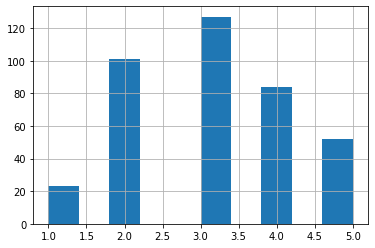

In [68]:
info(students.goout)

     health
5.0     138
3.0      89
4.0      63
1.0      47
2.0      43
Пропущенных значений - 15


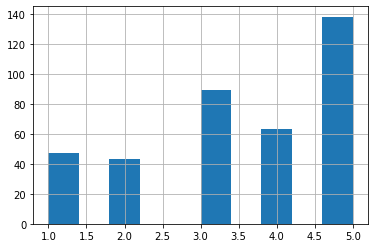

In [69]:
info(students.health)

       absences
0.0         111
2.0          60
4.0          53
6.0          31
8.0          21
10.0         17
12.0         12
14.0         12
3.0           8
16.0          7
7.0           6
5.0           5
18.0          5
20.0          4
22.0          3
9.0           3
1.0           3
15.0          2
13.0          2
11.0          2
25.0          1
54.0          1
385.0         1
26.0          1
56.0          1
24.0          1
212.0         1
21.0          1
75.0          1
30.0          1
19.0          1
38.0          1
40.0          1
23.0          1
17.0          1
28.0          1
Пропущенных значений - 12


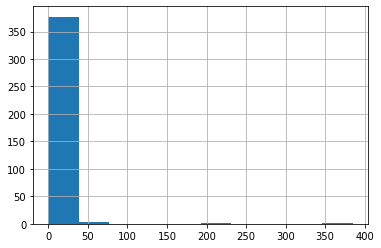

In [70]:
info(students.absences)

Вероятно, значения 212 и 385 являются ошибками, т.к. выходят за рамки кол-ва учебных дней и кол-ва дней в году соответственно. Удалим их из датасета.

In [71]:
students = students[~students.absences.isin([212.0,385.0])]
len(students)

393

Посмотрим еще раз не получившийся результат? определим выбросы и удалим их.

      absences
0.0        111
2.0         60
4.0         53
6.0         31
8.0         21
10.0        17
14.0        12
12.0        12
3.0          8
16.0         7
7.0          6
5.0          5
18.0         5
20.0         4
1.0          3
22.0         3
9.0          3
15.0         2
13.0         2
11.0         2
54.0         1
25.0         1
17.0         1
26.0         1
56.0         1
23.0         1
28.0         1
21.0         1
75.0         1
30.0         1
19.0         1
38.0         1
40.0         1
24.0         1
Пропущенных значений - 12


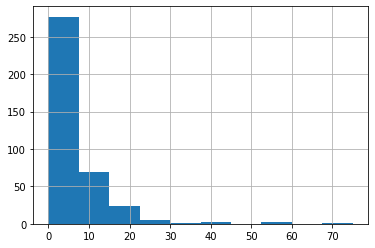

In [72]:
info(students.absences)

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


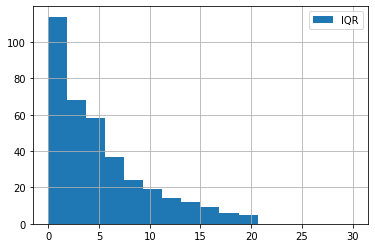

In [73]:
median = students.absences.median()
IQR = students.absences.quantile(0.75) - students.absences.quantile(0.25)
perc25 = students.absences.quantile(0.25)
perc75 = students.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), 
      '75-й перцентиль: {},'.format(perc75), 
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
students.absences.loc[students.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 16, 
                                                                                              range = (0, 30),
                                                                                              label = 'IQR')
plt.legend();

Выбросами считаем значения больше 30, т.к. пропуск более 30 учебных дней скорее всего приведет к переводу ученика на домашнее обучение.

In [74]:
students = students.absences.loc[students.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
len(students)

366

       score
50.0      54
55.0      46
0.0       37
75.0      33
65.0      31
40.0      31
60.0      31
70.0      27
45.0      27
80.0      16
30.0      15
90.0      12
35.0       9
25.0       7
85.0       6
95.0       5
100.0      1
20.0       1
Пропущенных значений - 6


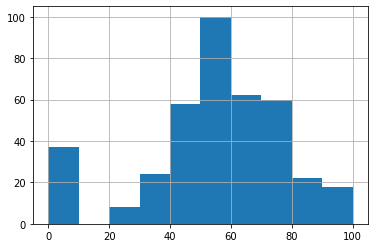

In [80]:
info(students.score)

Числовые колонки содержат достаточно чистые данные, мало ошибок и пропущенных значений.

### Просмотр строковых столбцов

    school
GP     349
MS      46
Пропущенных значений - 0


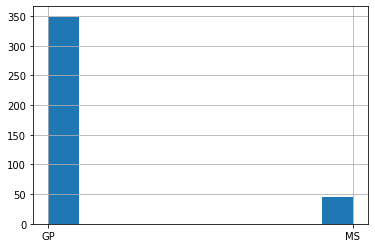

In [81]:
info(students.school)

   sex
F  208
M  187
Пропущенных значений - 0


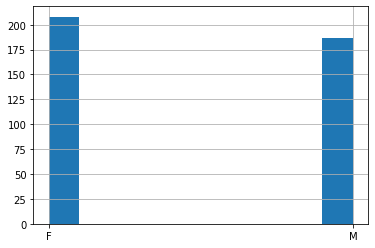

In [82]:
info(students.sex)

   address
U      295
R       83
Пропущенных значений - 17


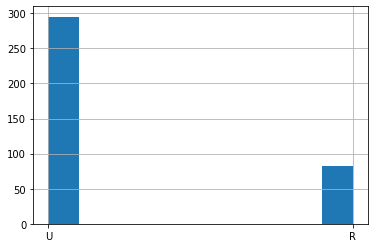

In [83]:
info(students.address)

     famsize
GT3      261
LE3      107
Пропущенных значений - 27


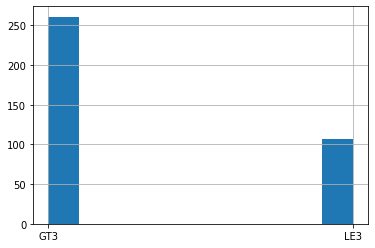

In [84]:
info(students.famsize)

   pstatus
T      314
A       36
Пропущенных значений - 45


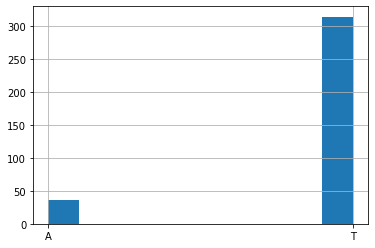

In [85]:
info(students.pstatus)

          mjob
other      133
services    98
at_home     58
teacher     55
health      32
Пропущенных значений - 19


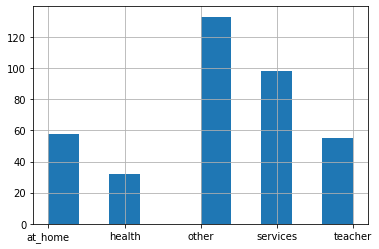

In [86]:
info(students.mjob)

          fjob
other      197
services   102
teacher     29
at_home     16
health      15
Пропущенных значений - 36


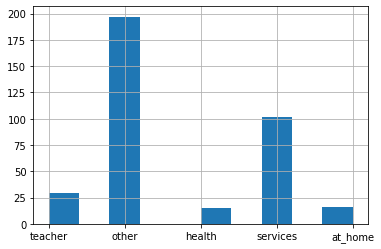

In [87]:
info(students.fjob)

            reason
course         137
home           104
reputation     103
other           34
Пропущенных значений - 17


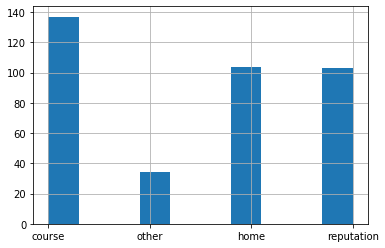

In [88]:
info(students.reason)

        guardian
mother       250
father        86
other         28
Пропущенных значений - 31


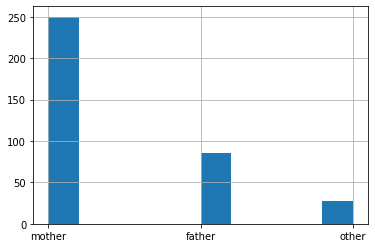

In [89]:
info(students.guardian)

     schoolsup
no         335
yes         51
Пропущенных значений - 9


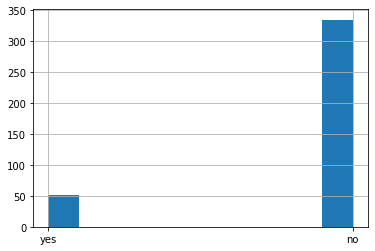

In [90]:
info(students.schoolsup)

     famsup
yes     219
no      137
Пропущенных значений - 39


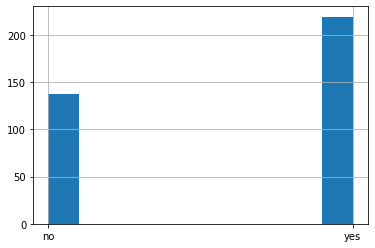

In [91]:
info(students.famsup)

     paid
no    200
yes   155
Пропущенных значений - 40


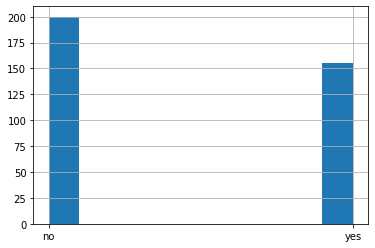

In [92]:
info(students.paid)

     activities
yes         195
no          186
Пропущенных значений - 14


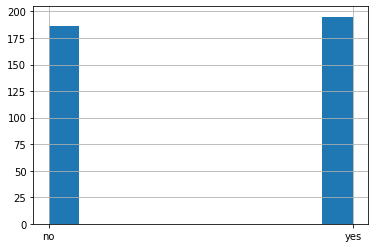

In [93]:
info(students.activities)

     nursery
yes      300
no        79
Пропущенных значений - 16


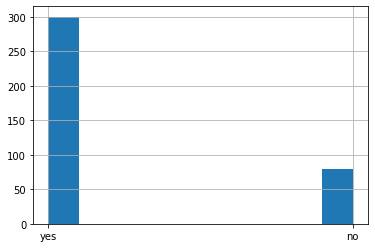

In [94]:
info(students.nursery)

     higher
yes     356
no       19
Пропущенных значений - 20


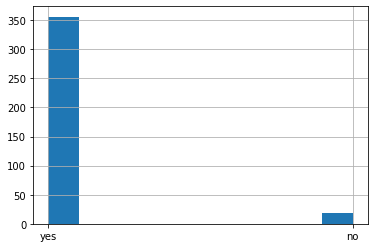

In [95]:
info(students.higher)

     internet
yes       305
no         56
Пропущенных значений - 34


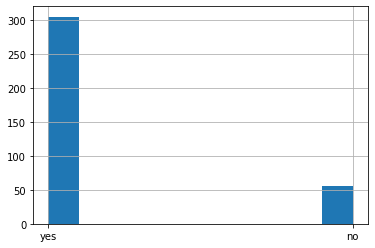

In [96]:
info(students.internet)

     romantic
no        240
yes       124
Пропущенных значений - 31


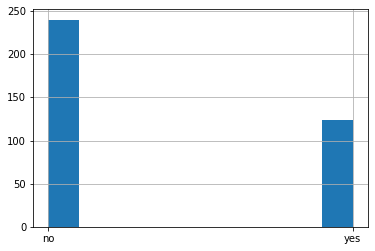

In [97]:
info(students.romantic)

Строковые данные содержат большее кол-во пропусков.

In [ ]:
# Можно было бы заменить все NaN на None, как обсуждалось в группе по проекту, но в таком случае перестает работать корреляция.
# students = students.where(pd.notnull(students), None)

# Поиск зависимостей
Посмотрим корреляцию числовых значений

In [113]:
students.corr()

,age,medu,fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.161704,-0.138018,0.081508,-0.015556,0.228047,0.015556,0.068899,0.029023,0.135107,-0.065946,0.093592,-0.155726
medu,-0.161704,1.000000,0.275598,-0.173515,0.078589,-0.245463,-0.078589,-0.010050,0.025335,0.064164,-0.045051,-0.011944,0.213349
fedu,-0.138018,0.275598,1.000000,0.030646,0.057199,-0.150821,-0.057199,0.040577,-0.066556,-0.023282,0.027251,0.004695,0.078573
traveltime,0.081508,-0.173515,0.030646,1.000000,-0.102206,0.064699,0.102206,-0.016857,-0.021937,0.037636,-0.021531,-0.048215,-0.070559
studytime,-0.015556,0.078589,0.057199,-0.102206,1.000000,-0.178992,-1.000000,0.045894,-0.121969,-0.051280,-0.080016,-0.026544,0.115741
failures,0.228047,-0.245463,-0.150821,0.064699,-0.178992,1.000000,0.178992,-0.022655,0.098382,0.120914,0.081284,0.057391,-0.344338
studytime_granular,0.015556,-0.078589,-0.057199,0.102206,-1.000000,0.178992,1.000000,-0.045894,0.121969,0.051280,0.080016,0.026544,-0.115741
famrel,0.068899,-0.010050,0.040577,-0.016857,0.045894,-0.022655,-0.045894,1.000000,0.175743,0.081154,0.077474,-0.082609,0.057112
freetime,0.029023,0.025335,-0.066556,-0.021937,-0.121969,0.098382,0.121969,0.175743,1.000000,0.296437,0.061575,0.009292,0.019026
goout,0.135107,0.064164,-0.023282,0.037636,-0.051280,0.120914,0.051280,0.081154,0.296437,1.000000,-0.015608,-0.048738,-0.129685


Полная корреляция столбцов studytime и studytime_granular позволяют не брать последний в рассчет.

Образование родителей (medu и fedu) и кол-во внеучебных неудач (failures) больше других оказывают влияние на успеваемость. Т.е. чем выше образование родителей, тем более успешный ребенок в жизни в целом, в том числе и в учебе. 

Также можно увидеть корреляцию возраста (age) и кол-ва внеучебных неудач (failures). Чем страше ребенок, тем хуже успеваемость. Можно предположить, что более молодые родители имеют лучшее образование, либо растущие дети начинают больше времени уделять друзьям (gout) а не учебе (studytime).

Присутствует также логическая связь влияния пропусков занятий (absences) на успеваемость, эти данные мы тоже возьмем в модель.

Построим графики и посмотрим на распределения строковых данных

In [114]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=students.loc[students.loc[:, column].isin(students.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=0)
    ax.set_title('Boxplot for ' + column)
    plt.show()

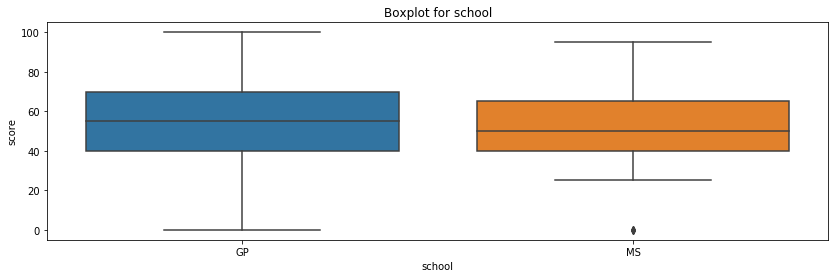

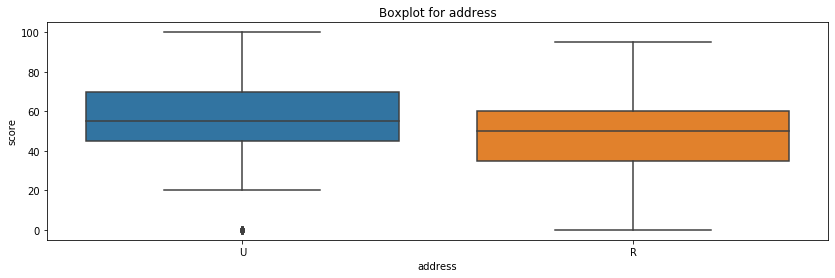

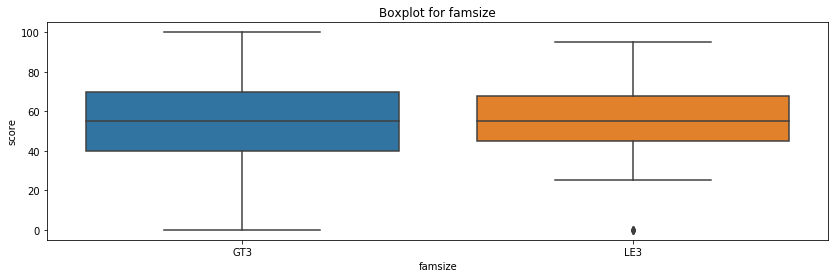

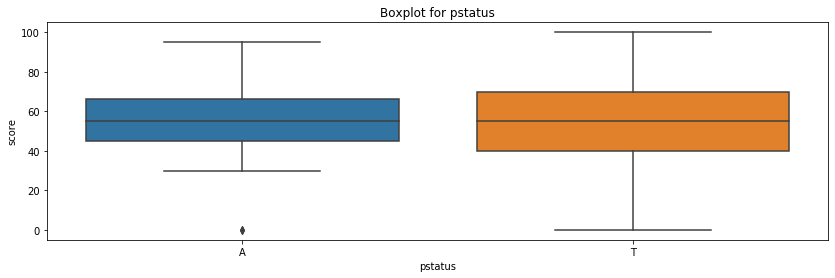

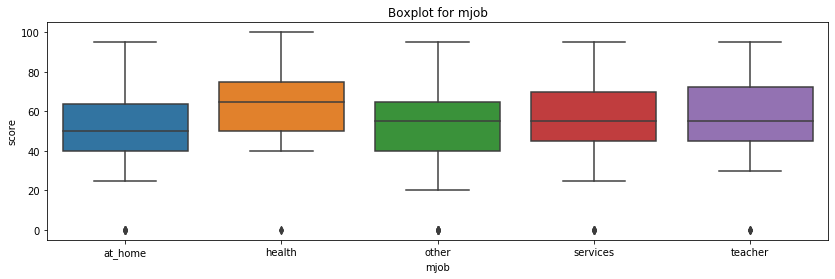

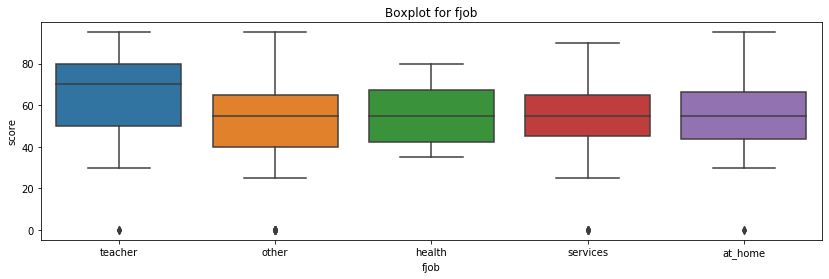

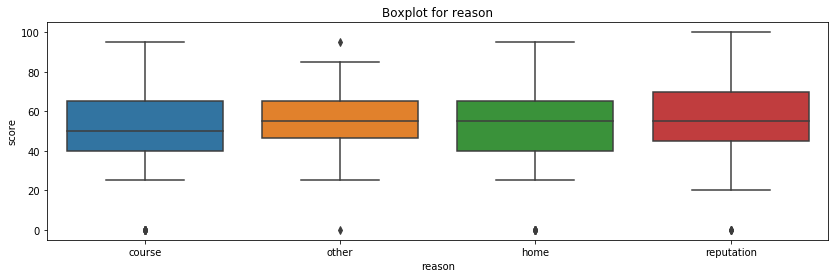

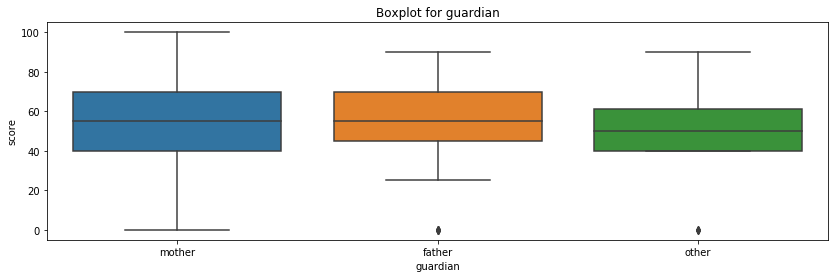

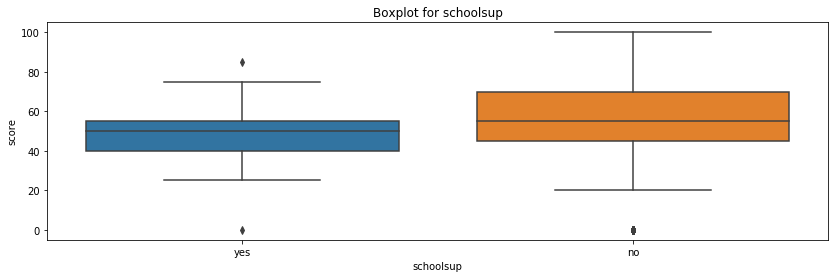

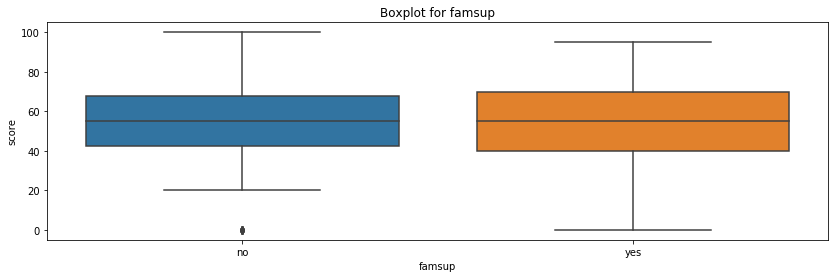

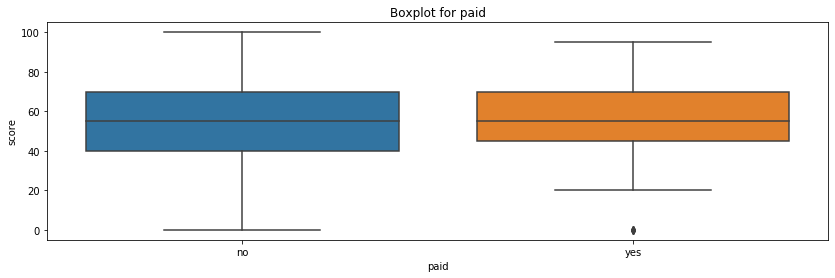

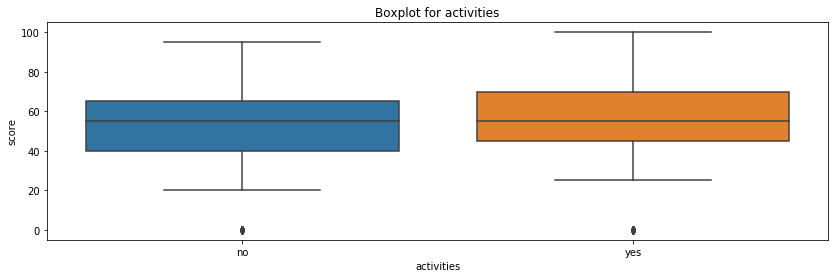

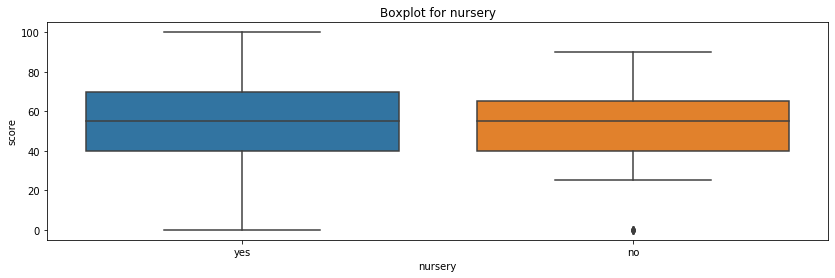

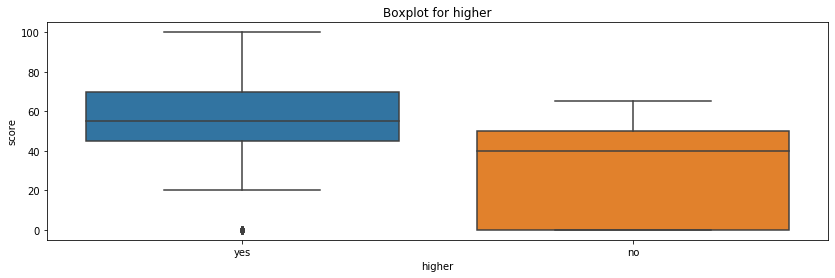

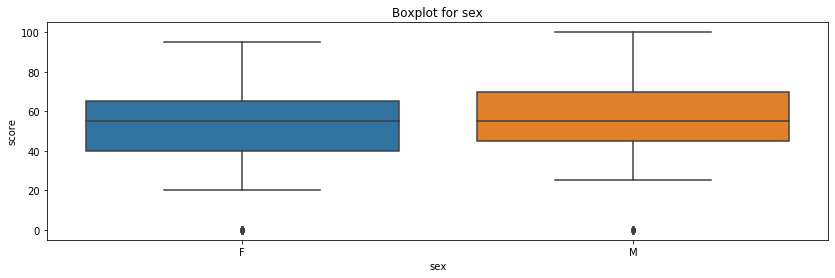

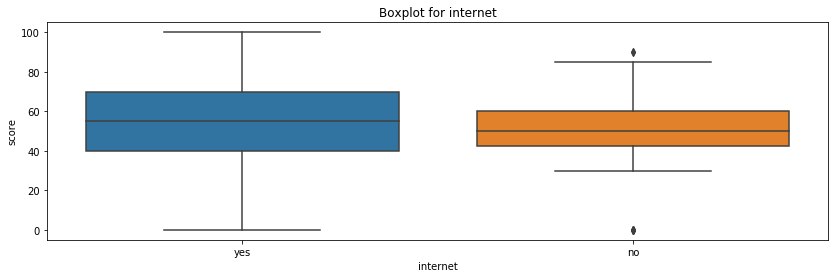

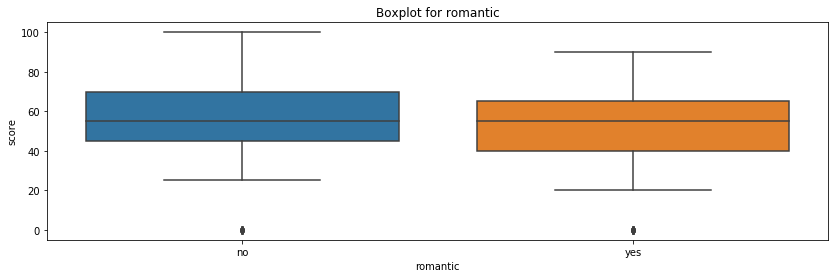

In [115]:
for col in ['school', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 
            'activities', 'nursery', 'higher', 'sex', 'internet', 'romantic']:
    get_boxplot(col)

По условию задачи поиска группы риска, оцениваем факторы влияющие на ухудшение успеваемости.
Из графиков мы видим, что минимальных значений больше у учащихся:
<ul>
    <li>школы GP</li>
    <li>живущих за городом (address)</li>
    <li>с размеров семьи больше 3 человек (famsize)</li>
    <li>родители которых проживают совместно (pstatus)
    <li>опекуном которых является мать (guardian) - статистическое большинство
    <li>без дополнительной образовательной поддержки
    <li>имеющих учебную поддержку дома (famsup)
    <li>не занимающихся дополнительно (платно) (paid)
    <li>посещавших детский сад
    <li>не собирающихся получать высшее образование (higher) - сильно влияет
    <li>женского пола
    <li>имеющих доступ к интернету
    <li>состоящих в романтических отношениях
</ul>

Сделаем тест Стюдента

In [116]:
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:20]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'],
                     students.loc[students.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [117]:
for col in ['school', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
            'activities', 'nursery', 'higher', 'sex', 'internet', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки mjob


C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### Собираем датасет для модели
Немного выводов:
<ol>
    <li>В целом, сильно влияет образование родителей. Они коррелируют достаточно сильно, но я решил не объединять, чтобы выявить будущие зависимости от пола родителей. Образование отца сильнее влияет на успеваемость, но также выделяется позиция матери преподавателя.</li>
    <li>Также сильно влияют на успеваемость планы учащегося поступать в высшее учебное заведение. Если таких планов нет - то и мотивация соответствующая.</li>
    <li>Остальные параметры в меньшей степени влияют на результат, но их сумма может оказать решающее воздействие.</li>
</ol>

In [118]:
model = students[['school','age','sex','address', 'medu', 'fedu', 'mjob', 'fjob', 'studytime', 'failures','romantic','schoolsup','higher', 'goout', 'absences', 'score']]
model

,school,age,sex,address,medu,fedu,mjob,fjob,studytime,failures,romantic,schoolsup,higher,goout,absences,score
0,GP,18,F,U,4.0,4.0,at_home,teacher,2.0,0.0,no,yes,yes,4.0,6.0,30.0
1,GP,17,F,U,1.0,1.0,at_home,other,2.0,0.0,no,no,yes,3.0,4.0,30.0
2,GP,15,F,U,1.0,1.0,at_home,other,2.0,3.0,NaN,yes,yes,2.0,10.0,50.0
3,GP,15,F,U,4.0,2.0,health,NaN,3.0,0.0,yes,no,yes,2.0,2.0,75.0
4,GP,16,F,U,3.0,3.0,other,other,2.0,0.0,no,no,yes,2.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,20,M,U,2.0,2.0,services,services,2.0,2.0,no,no,yes,4.0,212.0,45.0
391,MS,17,M,U,3.0,1.0,services,services,1.0,0.0,no,no,yes,5.0,3.0,80.0
392,MS,21,M,R,1.0,1.0,other,other,1.0,3.0,no,NaN,NaN,3.0,3.0,35.0
393,MS,18,M,R,3.0,2.0,services,other,1.0,0.0,no,no,yes,1.0,0.0,50.0
